In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import math
import scipy
import copy
import os
import matplotlib.pyplot as plt

# llops, which provides backend-independent operations
import llops as yp
import llops.operators as ops

# coptic
from comptic import simulation, noise

# Project-specific imports
from htdeblur import blurkernel, analysis

yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('float32')
# plt.style.use('publication')

# Figure output directory
figure_output_directory = os.path.expanduser('/Users/zfphil/Dropbox/Berkeley/My Talks/fom2019/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Save forward Model Figures

<IPython.core.display.Javascript object>


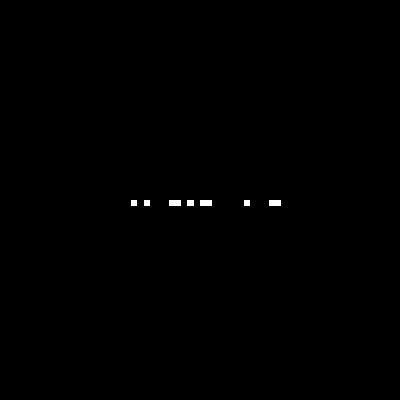

In [30]:
# Generater Blur kernel
vector, dnf = blurkernel.vector(pulse_count=12)
kernel = blurkernel.fromVector(vector, (64,64))

plt.figure(figsize=(4,4))
plt.imshow(kernel)
yp.savefig(figure_output_directory + '_kernel_crop.png')

## Multi-Frame Figure

<IPython.core.display.Javascript object>


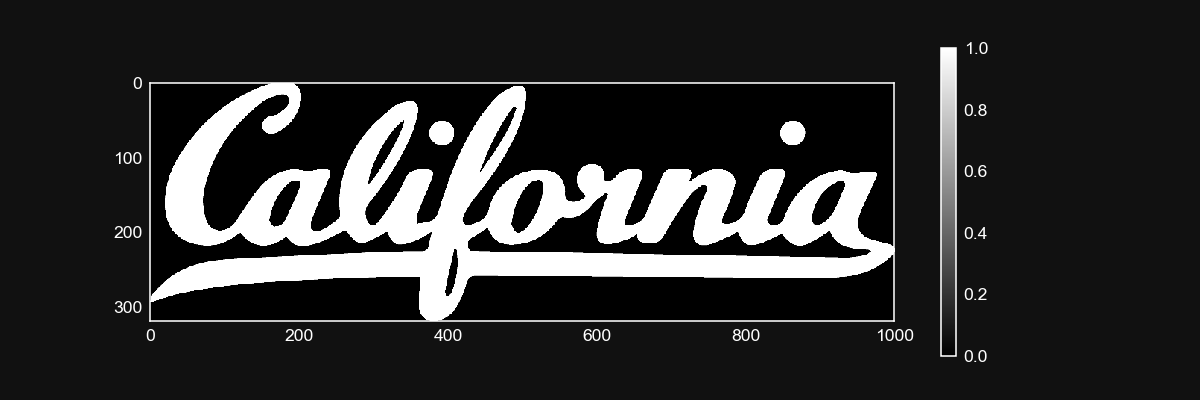

In [31]:
california = simulation.california(min_value=0, max_value=1, invert=False, shape=(320, 1000))
plt.figure()
plt.imshow(california)
plt.colorbar()

<IPython.core.display.Javascript object>


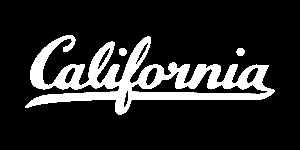

<IPython.core.display.Javascript object>


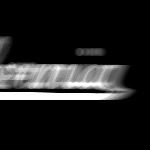

<IPython.core.display.Javascript object>


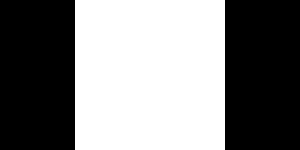

<IPython.core.display.Javascript object>


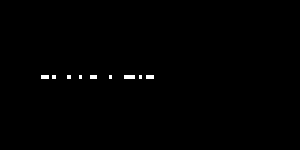

<IPython.core.display.Javascript object>


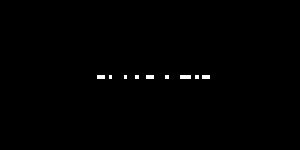

<IPython.core.display.Javascript object>


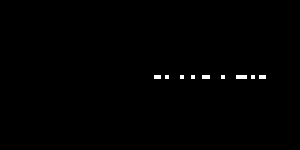

In [48]:
object_shape = (600, 1200)
image_shape = (600, 600)

# Generate object
object_true = np.abs(yp.pad(california, object_shape, center=True))

# Define Crop ROIs
roi_list = (yp.Roi(start=(0,0), shape=image_shape, input_shape=object_shape),
            yp.Roi(start=(0, object_shape[1] // 4), shape=image_shape, input_shape=object_shape), 
            yp.Roi(start=(0, object_shape[1] // 2), shape=image_shape, input_shape=object_shape))

# Generater Blur kernel
vector, dnf = blurkernel.vector(pulse_count=50)
kernel = blurkernel.fromVector(vector, object_shape)

# Define Operators
C = ops.Convolution(kernel)
G = ops.Segmentation(roi_list)

# Crop to measurements
measurement_list = ops.VecSplit(G * C * object_true,3)

plt.figure(figsize=(3,1.5))
plt.imshow(object_true)
plt.axis('off')
yp.savefig(figure_output_directory + 'system_ground_truth.png')

plt.figure(figsize=(1.5,1.5))
for index, measurement in enumerate(measurement_list):
    plt.clf()
    plt.imshow(measurement)
    plt.axis('off')
    yp.savefig(figure_output_directory + 'system_measurement_%d.png' % index)
    
plt.figure(figsize=(3,1.5))
plt.imshow(roi_list[1].mask)
plt.axis('off')
yp.savefig(figure_output_directory + 'mask.png')

vector, dnf = blurkernel.vector(pulse_count=15)
kernel_crop = blurkernel.fromVector(vector, (40,80))
plt.figure(figsize=(3,1.5))
plt.imshow(yp.circshift(kernel_crop, (0, -15)))
plt.axis('off')
yp.savefig(figure_output_directory + 'kernel_0.png')

plt.figure(figsize=(3,1.5))
plt.imshow(yp.circshift(kernel_crop, (0, 0)))
plt.axis('off')
yp.savefig(figure_output_directory + 'kernel_1.png')

plt.figure(figsize=(3,1.5))
plt.imshow(yp.circshift(kernel_crop, (0, 15)))
plt.axis('off')
yp.savefig(figure_output_directory + 'kernel_2.png')

## Define Constants

<IPython.core.display.Javascript object>


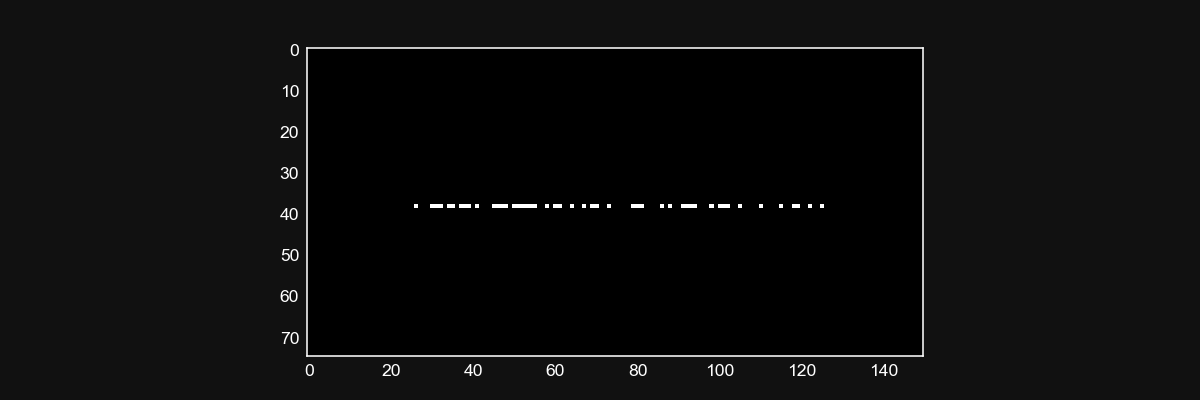

In [42]:
plt.figure()
plt.imshow(kernel_crop)

In [2]:


# Get system parameters
system_params = analysis.getDefaultSystemParams()

pulse_count = 25

## Calculate SNR Improvement

In [3]:
t_strobe = 1e-5
t_coded = t_strobe * pulse_count
dnf_coded = analysis.getOptimalDnf(pulse_count*2)
system_params_illum_copy =copy.deepcopy(system_params)
system_params_illum_copy['camera_ad_conversion'] = 0.46
system_params_illum_copy['camera_quantum_efficency'] = 0.9
system_params_illum_copy['illuminance'] = 1000
system_params_illum_copy['readout_noise'] = 10
system_params_illum_copy['dark_current'] = 0.5
system_params_illum_copy['velocity_max'] = 2
snr_coded = analysis.exposureTimeToSnr(t_coded, dnf=dnf_coded, **system_params_illum_copy)
snr_strobe = analysis.exposureTimeToSnr(t_strobe, dnf=1, **system_params_illum_copy)
# print(snr_coded / snr_strobe)
print(snr_coded)

2.0860933665111996


In [5]:
illuminance_list = 10000, 2000, 10000
readout_noise_list = 10, 20, 40
frame_rate = 3

# Initialize lists
snr_strobed_list = []
snr_sns_list = []
snr_coded_list = []
snr_coded_raw_list = []

for illuminance, readout_noise in zip(illuminance_list, readout_noise_list):   
    # Define illuminance
    system_params_illum = copy.deepcopy(system_params)
    system_params_illum['illuminance'] = illuminance
    system_params_illum['readout_noise'] = readout_noise
    
    # Calculate Photon Pixel rate
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(**system_params)

    # SNS
    t_sns, dnf_sns = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'stop_and_stare', pulse_count=pulse_count, **system_params_illum)
    snr_sns = analysis.exposureTimeToSnr(t_sns, dnf=dnf_sns, **system_params_illum)
    snr_sns_list.append(snr_sns)

    # Strobed
    t_strobe, dnf_strobe = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'strobe', pulse_count=pulse_count, **system_params_illum)
    snr_strobe = analysis.exposureTimeToSnr(t_strobe, dnf=dnf_strobe, **system_params_illum)
    snr_strobed_list.append(snr_strobe)

    # Coded
    t_coded, dnf_coded = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'code', pulse_count=pulse_count, **system_params_illum)
    snr_coded_list.append(analysis.exposureTimeToSnr(t_coded, dnf=dnf_coded, **system_params_illum))
    snr_coded_raw_list.append( analysis.exposureTimeToSnr(t_coded, dnf=1, **system_params_illum))

print(snr_strobed_list)
print(snr_coded_list)
print(snr_coded_list[1] / snr_strobed_list[1])
print(snr_coded_list[2] / snr_strobed_list[2])

[7.483303971881273, 2.043785264211919, 7.483303971881273]
[5.504652774291126, 2.333706854357787, 5.504652774291126]
1.141855211123494
0.7355912301538219


## Generate Blurry and Strobed Groups of Images as Examples
https://www.ptgrey.com/support/downloads/10501

<IPython.core.display.Javascript object>


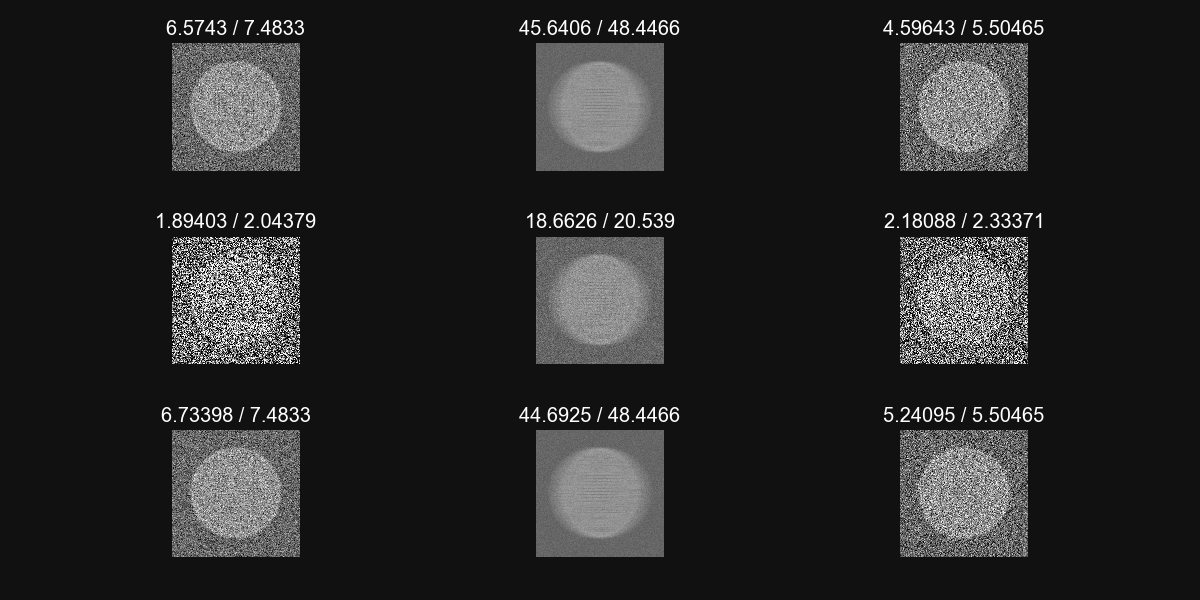

In [7]:
# Generate object
object_true = np.abs(yp.pad(simulation.testObject('ucbseal', shape=(400,400)), (512,512), center=True, pad_value='edge')) * 100

# Generater Blur kernel
vector, dnf = blurkernel.vector(pulse_count=30)
kernel = blurkernel.fromVector(vector, object_true.shape)

# Define SNR function
snr = lambda x: noise.snr(x, signal_roi=yp.Roi(shape=(40, 40), start=(280, 30)), noise_roi=yp.Roi(shape=(10, 10), start=(40, 40)))

# Generate blurry object
object_blurry = yp.convolve(object_true, kernel)

# Define SNR to generate images from
measurement_list = []
for snr_strobed, snr_coded, snr_coded_raw in zip(snr_strobed_list, snr_coded_list, snr_coded_raw_list):
    data_sublist = []
    
    # Generate strobed data
    data_sublist.append(noise.add(object_true, snr=snr_strobed))
    
    # Generate coded measurement
    data_sublist.append(noise.add(object_blurry, snr=snr_coded_raw))
    
    # Deconvolve blurry measurement
    data_sublist.append(yp.deconvolve(data_sublist[-1], kernel, reg=1e-3))
    
    # Append to measurement list
    measurement_list.append(data_sublist)
    

plt.figure(figsize=(12, 6))

index = 0
clim=(50,150)
cmap = 'gray'
plt.subplot(331)
plt.imshow(measurement_list[index][0], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][0]), snr_strobed_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(332)
plt.imshow(measurement_list[index][1], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][1]), snr_coded_raw_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(333)
plt.imshow(measurement_list[index][2], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][2]), snr_coded_list[index]))
plt.clim(clim)
plt.axis('off')

index = 1
plt.subplot(334)
plt.imshow(measurement_list[index][0], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][0]), snr_strobed_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(335)
plt.imshow(measurement_list[index][1], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][1]), snr_coded_raw_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(336)
plt.imshow(measurement_list[index][2], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][2]), snr_coded_list[index]))
plt.clim(clim)
plt.axis('off')

index = 2
plt.subplot(337)
plt.imshow(measurement_list[index][0], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][0]), snr_strobed_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(338)
plt.imshow(measurement_list[index][1], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][1]), snr_coded_raw_list[index]))
plt.clim(clim)
plt.axis('off')
plt.subplot(339)
plt.imshow(measurement_list[index][2], cmap=cmap)
plt.title('%g / %g' % (snr(measurement_list[index][2]), snr_coded_list[index]))
plt.clim(clim)
plt.axis('off')

plt.tight_layout()

## Sweep System Pulse Count
The parameter pulse_count is a scaler which represents the ratio of the amount of pulses used vs the amount of pulses which would saturate the camera

In [8]:
# Set frame rate
frame_rate = 10

# Calculate Photon Pixel rate
photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(**system_params)

# Stop and stare signal-to-noise
t_sns, dnf_sns = analysis.frameRateToExposure(frame_rate, photon_pixel_rate,'stop_and_stare', **system_params)
snr_sns = analysis.exposureTimeToSnr(t_sns, dnf=dnf_sns, **system_params)
counts_sns, noise_dependent, noise_independent = analysis.exposureTimeToNoiseComponents(t_sns, dnf=dnf_sns, **system_params)
noise_independent = 1 if noise_independent == 0 else noise_independent
print("SNS illumination at %d fps will have exposure %g seconds, %g counts, %g SNR (dnf = %g), and a noise ratio of %g" % (frame_rate, t_sns, counts_sns, snr_sns, dnf_sns, noise_dependent / noise_independent))

# Strobed signal-to-noise
t_strobe, dnf_strobe = analysis.frameRateToExposure(frame_rate, photon_pixel_rate,'strobe', **system_params)
snr_strobe = analysis.exposureTimeToSnr(t_strobe, dnf=dnf_strobe, **system_params)
counts_strobe, noise_dependent, noise_independent = analysis.exposureTimeToNoiseComponents(t_strobe, dnf=dnf_strobe, **system_params)
noise_independent = 1 if noise_independent == 0 else noise_independent
print("Strobed illumination at %d fps will have exposure %g seconds, %g counts, %g SNR (dnf = %g), and a noise ratio of %g" % (frame_rate, t_strobe, counts_strobe, snr_strobe, dnf_strobe, noise_dependent / noise_independent))

# Loop over illumination beta
for pulse_count in np.arange(1,1000,10):
    t_coded, dnf_coded = analysis.frameRateToExposure(frame_rate, photon_pixel_rate,'code', pulse_count=pulse_count, **system_params)
    snr_coded = analysis.exposureTimeToSnr(t_coded, dnf=dnf_coded, **system_params)
    counts_coded, noise_dependent, noise_independent = analysis.exposureTimeToNoiseComponents(t_coded, dnf=dnf_coded, **system_params)
    noise_independent = 1 if noise_independent == 0 else noise_independent
    print("pulse_count=%g coded illumination at %d fps will have exposure %g seconds, %g counts, %g SNR (dnf = %g), and a noise ratio of %g" % (pulse_count, frame_rate, t_coded, counts_coded, snr_coded, dnf_coded, noise_dependent / noise_independent))

SNS illumination at 10 fps will have exposure 0 seconds, 0 counts, 0 SNR (dnf = 1), and a noise ratio of 0
Strobed illumination at 10 fps will have exposure 2.6e-05 seconds, 4.34726 counts, 0.504009 SNR (dnf = 1), and a noise ratio of 0.249119
pulse_count=1 coded illumination at 10 fps will have exposure 5.2e-05 seconds, 8.69452 counts, 0.562571 SNR (dnf = 1.74164), and a noise ratio of 0.352308
pulse_count=11 coded illumination at 10 fps will have exposure 0.000286 seconds, 47.8199 counts, 0.847361 SNR (dnf = 5.19802), and a noise ratio of 0.826235
pulse_count=21 coded illumination at 10 fps will have exposure 0.000546 seconds, 91.2925 counts, 0.913261 SNR (dnf = 7.86982), and a noise ratio of 1.14161
pulse_count=31 coded illumination at 10 fps will have exposure 0.000806 seconds, 134.765 counts, 0.932052 SNR (dnf = 10.1031), and a noise ratio of 1.38704
pulse_count=41 coded illumination at 10 fps will have exposure 0.001066 seconds, 178.238 counts, 0.935801 SNR (dnf = 12.0875), and a

## Plot SNR vs Frame Rate for 10 Lux

<IPython.core.display.Javascript object>


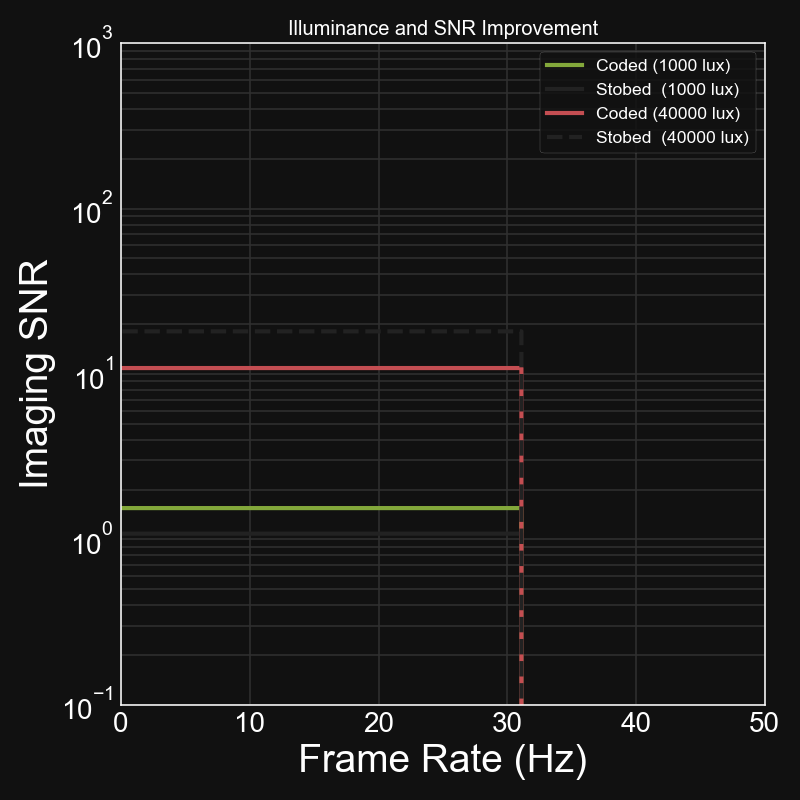

/Users/zfphil/.conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [10]:
# Define which frame rates to use
frame_rates = np.arange(0.1, 50, 1)

# Define number of pulses for coded
pulse_count = 30

# Define which illuminance to use
illuminance_list =  [1000, 40000]

# Initialize lists
snr_strobe_list = []
snr_sns_list = []
snr_coded_list = [] # list of lists

# Loop over frame rates
for index, frame_rate in enumerate(frame_rates):
        
    # Loop over illuminance
    snr_sns_sublist, snr_strobed_sublist, snr_coded_sublist = [], [], []
    for illuminance in illuminance_list:
        
        # Define illuminance
        system_params_illum = copy.deepcopy(system_params)
        system_params_illum['illuminance'] = illuminance
        
        # Calculate Photon Pixel rate
        photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(**system_params_illum)
        
        # SNS
        t_sns, dnf_sns = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'stop_and_stare', pulse_count=pulse_count, **system_params_illum)
        snr_sns = analysis.exposureTimeToSnr(t_sns, dnf=dnf_sns, **system_params_illum)
        snr_sns_sublist.append(snr_sns)
        
        # Strobed
        t_strobe, dnf_strobe = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'strobe', pulse_count=pulse_count, **system_params_illum)
        snr_strobe = analysis.exposureTimeToSnr(t_strobe, dnf=dnf_strobe, **system_params_illum)
        snr_strobed_sublist.append(snr_strobe)
    
        # Coded
        t_coded, dnf_coded = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'code', pulse_count=pulse_count, **system_params_illum)
        snr_coded = analysis.exposureTimeToSnr(t_coded, dnf=dnf_coded, **system_params_illum)
        snr_coded_sublist.append(snr_coded)
        
    # Append
    snr_sns_list.append(snr_sns_sublist)
    snr_strobe_list.append(snr_strobed_sublist)
    snr_coded_list.append(snr_coded_sublist)
    
snr_sns_list_transpose = np.asarray(snr_sns_list).T.tolist()
snr_strobe_list_transpose = np.asarray(snr_strobe_list).T.tolist()
snr_coded_list_transpose = np.asarray(snr_coded_list).T.tolist()

# Perform plotting
lw = 3
plt.figure(figsize=(8, 8))

# Loop over illuminance
c = ['g', 'r', 'b', 'y']
for index, (illuminance, snr_sns, snr_strobe, snr_coded) in enumerate(zip(illuminance_list, snr_sns_list_transpose, snr_strobe_list_transpose, snr_coded_list_transpose)):
    plt.semilogy(frame_rates, snr_coded, linewidth=lw, label='Coded (%d lux)' % illuminance, c=c[index])
#     plt.semilogy(frame_rates, snr_sns, 'r-', linewidth=lw, label='Stop and Stare  (%d lux)' % illuminance)

    if index == 0:
        plt.semilogy(frame_rates, snr_strobe, 'k-', linewidth=lw, label='Stobed  (%d lux)' % illuminance)
    else:
        plt.semilogy(frame_rates, snr_strobe, 'k--', linewidth=lw, label='Stobed  (%d lux)' % illuminance)
    
# Configure figure
plt.legend()
plt.xlabel('Frame Rate (Hz)', fontsize=28)
plt.ylabel('Imaging SNR', fontsize=28)
plt.ylim((1e-1, 1000))
plt.xlim((0, 50))
plt.grid('on', which='both')
plt.title('Illuminance and SNR Improvement')

# Set up ticks
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

# Save
plt.tight_layout()
# plt.savefig(os.path.join(figure_directory, 'snr_plot.png'))

## Generate Example Images

In [12]:
index = 100

snr_coded_0 = snr_coded_list_transpose[0][index]
snr_coded_1 = snr_coded_list_transpose[1][index]
snr_strobe_0 = snr_strobe_list_transpose[0][index]
snr_strobe_1 = snr_strobe_list_transpose[1][index]

# Generate object
object_true = np.abs(sim.ucb())

# Define SNR to generate images from
snr_list = [snr_coded_0, snr_strobe_0, snr_coded_1, snr_strobe_1]

noisy_object_list = []
for snr in snr_list:
    noisy_object_list.append(noise.add(object_true, snr=snr))
    
# Show result

plt.figure(figsize=(2,6))
clim = [0.5, 1.5]
for index, (noisy, snr) in enumerate(zip(noisy_object_list, snr_list)):
    plt.subplot(411 + index)
    plt.imshow(np.abs(noisy))
#     plt.title('SNR: %g' % snr)
    plt.clim(clim)
    plt.axis('off')
    
plt.savefig(os.path.join(figure_directory, 'snr_images.png'))

IndexError: list index out of range